In [ ]:
import copy 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.optimize import minimize 
import IESDS
import order_k
import BFPSNS
import Linear_programming
from scipy.optimize import minimize_scalar
import QUAD as quad

import nashpy as nash

# this module contains the data
import hst 

In [3]:
df = pd.read_csv('auction_prices.csv')
p = df.values

### 1.

In [13]:
R = 100_000 
n = 5
k = 3
win_b = []
thetas = np.linspace(1, 5, 20)
for theta in thetas:
    v = np.random.gamma(k,theta,(R, n))
    p_spsb = np.sort(v, axis=1)[:,-2]
    p_spsb = np.mean(p_spsb)
    win_b.append(p_spsb)

print(win_b)

data_mean_p = np.mean(p)
print("Mean price:", data_mean_p)

[3.669177038314017, 4.443362696065085, 5.206601472706179, 5.984142794907622, 6.762981469165628, 7.5244011671733135, 8.293063555075358, 9.084875934963865, 9.848643903256699, 10.60873271556832, 11.378351889126074, 12.177049435672476, 12.911876103623127, 13.713345939204732, 14.456317367608404, 15.262167266064612, 16.056344880197315, 16.799030875790606, 17.594953444979332, 18.349319549479812]
Mean price: 8.436091118086878


In [15]:
win_b = []
thetas = np.linspace(1, 3, 100)
for theta in thetas:
    v = np.random.gamma(k,theta,(R, n))
    p_spsb = np.sort(v, axis=1)[:,-2]
    p_spsb = np.mean(p_spsb)
    win_b.append(p_spsb)
    if data_mean_p - p_spsb < 0.01:
        print("Theta:", theta)
        close_theta = theta
        break

v = np.random.gamma(k,close_theta,(R, n))
p_spsb = np.sort(v, axis=1)[:,-2]
p_spsb = np.mean(p_spsb)
print(p_spsb)

Theta: 2.313131313131313
8.482840548176634


### 2.

C:\Users\elias\AppData\Local\Temp\ipykernel_31836\1542761996.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return v - numer/denom


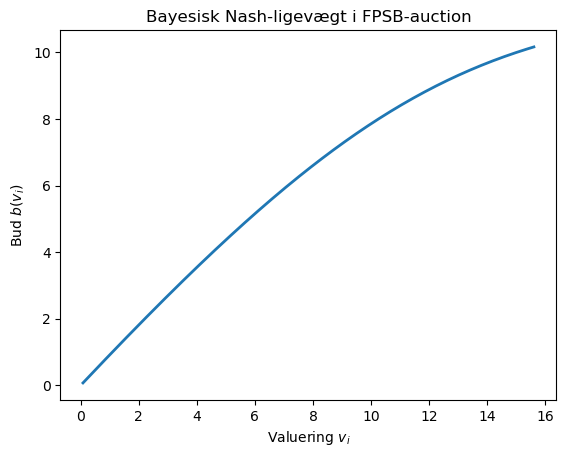

In [24]:
from scipy.stats import gamma
from scipy.integrate import quad

# k og theta er dem, du har estimeret i opgave 1
F_cdf_gamma = lambda v: gamma.cdf(v, a=k, scale=close_theta)

# antallet af bydere
n = 5  

# din generiske b(v)-funktion fra før:
def b(v, F_cdf, n):
    numer = quad(lambda x: F_cdf(x)**(n-1), 0, v)[0]
    denom = F_cdf(v)**(n-1)
    return v - numer/denom

# så beregner du b(v) over et grid af v-værdier
import numpy as np
import matplotlib.pyplot as plt

v_grid = np.linspace(0, np.quantile(p, 0.99), 200)   # fx fra 0 til 99%-kvantil af dine data
b_vals = [b(vi, F_cdf_gamma, n) for vi in v_grid]

plt.plot(v_grid, b_vals, lw=2)
plt.xlabel("Valuering $v_i$")
plt.ylabel("Bud $b(v_i)$")
plt.title("Bayesisk Nash-ligevægt i FPSB-auction")
plt.show()


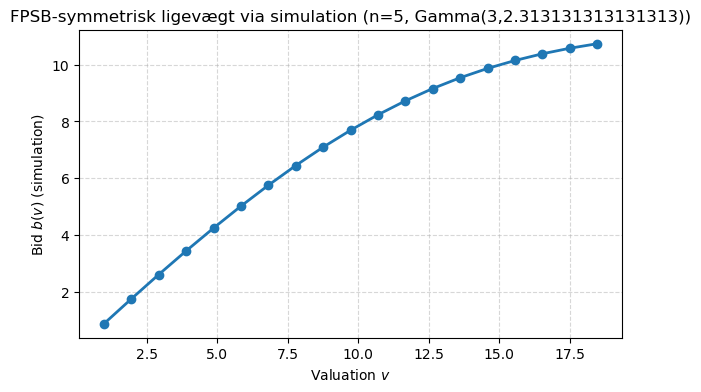

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

def Ev_largest(vi, v_sim_untruncated, N, R_used_min=42):
    assert v_sim_untruncated.ndim == 1, f'Expected 1-dimensional array'
    I = v_sim_untruncated <= vi
    v_sim = np.copy(v_sim_untruncated[I])
    drop_this_many = np.mod(v_sim.size, N)
    if drop_this_many>0:
        v_sim = v_sim[:-drop_this_many]
    R_used = int(v_sim.size / N)
    v_sim = np.reshape(v_sim, (N,R_used))
    assert R_used > R_used_min, f'Too few replications included: only {R_used}. Try increasing original R.'
    v_sim = np.sort(v_sim, 0)
    v_largest = v_sim[-1, :]
    Ev = np.mean(v_largest)
    return Ev

# --- 1) Parametre ---------------------------------------------------------
n         = 5            # samlet antal bydere
N         = n - 1        # antallet af "modsatrede" draws per simulering
k         = 3            # gamma-shape
theta_hat = close_theta          # din estimerede θ fra del 1
R         = 1_000_000    # total simulerede draws på hver "række"

np.random.seed(1337)

# --- 2) Simuler untrunkerede draws som (N,R) og flatten til 1-D -----------
#     Så får vi N*R uafhængige draws – præcis det, Ev_largest forventer.
v_untruncated = gamma(a=k, scale=theta_hat).rvs(size=(N, R)).flatten()

# --- 3) Vælg et grid af valuations og tøm output-array --------------------
vgrid = np.linspace(0, np.quantile(v_untruncated, 0.99), 20, endpoint=False)[1:]
Ev    = np.empty_like(vgrid)

# --- 4) Kald Ev_largest for hvert grid-punkt (uden at ændre funktionen!) ---
#     Hvis du får for få samples i bunden (meget små v), kan du 
#     enten droppe de første grunktioner eller disable assertion med 4. argument = 0.
for i, this_v in enumerate(vgrid):
    # eller: Ev[i] = Ev_largest(this_v, v_untruncated, N, 0)  # disables R_used_min
    Ev[i] = Ev_largest(this_v, v_untruncated, N, R_used_min=0)           # bruger default R_used_min=42

# --- 5) Plot resultatet ---------------------------------------------------
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(vgrid, Ev, 'o-', lw=2)
ax.set_xlabel("Valuation $v$")
ax.set_ylabel("Bid $b(v)$ (simulation)")
ax.set_title(f"FPSB-symmetrisk ligevægt via simulation (n={n}, Gamma(3,{theta_hat}))")
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()


C:\Users\elias\AppData\Local\Temp\ipykernel_31836\1542761996.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return v - numer/denom


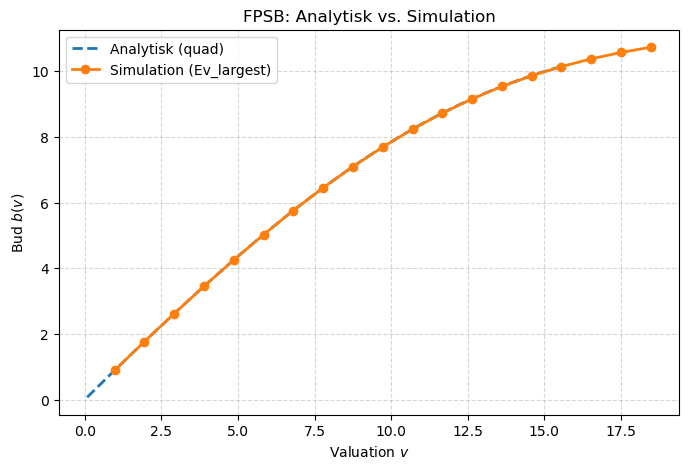

In [32]:
# Sørg for at bruge samme grid for begge:
# Analytisk:
v_grid = np.linspace(0, np.quantile(p, 0.99), 200)  
b_vals  = [b(vi, F_cdf_gamma, n)    for vi in v_grid]

# Simuleret:
vgrid_sim = np.linspace(0, np.quantile(v_untruncated, 0.99), 20, endpoint=False)[1:]
Ev_sim    = np.array([Ev_largest(v, v_untruncated, N, 0) for v in vgrid_sim])

# Hvis du vil sammenligne på samme grid, kan du f.eks. 
# interpolere Ev_sim op på v_grid eller 
# beregne b_vals på vgrid_sim i stedet. Men simpleste er to plots:
plt.figure(figsize=(8,5))
plt.plot(v_grid,   b_vals,  '--', lw=2, label='Analytisk (quad)')
plt.plot(vgrid_sim, Ev_sim, 'o-', lw=2, label='Simulation (Ev_largest)')
plt.xlabel("Valuation $v$")
plt.ylabel("Bud $b(v)$")
plt.title("FPSB: Analytisk vs. Simulation")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
